# Multiscale CNN Preprocessing 
Notebook used to preprocess DESI Spectra into 2D images and dump them into pickeld files. 

In [2]:
import numpy as np

from desispec.io import read_spectra
from desispec.interpolation import resample_flux
from desispec.spectra import stack as specstack
from desispec.spectra import stack as specstack
from desispec.spectra import stack as specstack
from desispec.coaddition import coadd_cameras
from desitarget.sv1.sv1_targetmask import bgs_mask as bgs_mask_sv1
from desitarget.sv2.sv2_targetmask import bgs_mask as bgs_mask_sv2
from desitarget.sv3.sv3_targetmask import bgs_mask as bgs_mask_sv3


from glob import glob
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table,vstack
from astropy.io import ascii, fits

import os
import platform
import pickle

 Couldn't install DESITRIP package on NERSC hence rescale and rebin code written below

In [3]:
def rescale_flux(flux):
    """Rescale flux so that it ranges from 0 to 1.
    Parameters
    ----------
    flux : ndarray
        Input flux array.
    Returns
    -------
    rsfl : ndarray
        Flux rescaled to range between 0 and 1.
    """

    if flux.ndim > 1:
        a, b = np.min(flux,axis=1)[:,None], np.max(flux,axis=1)[:,None]
    else:
        a, b = np.min(flux), np.max(flux)
    
    return (flux - a) / (b - a)

In [4]:
def rebin_flux(wave, flux, ivar=None, z=None, minwave=3600., maxwave=9800., nbins=3600, log=False, clip=False):
    """Rebin differential flux vs wavelength using desispec resample_flux.
    Parameters
    ----------
    wave : ndarray
        Input wavelength; assume units of Angstroms.
    flux : ndarray
        Input differential spectra as a function of wavelength.
    ivar : None or ndarray
        Inverse variance (weight) of spectra vs wavelength.
    z : None, float, or ndarray
        Known or estimated redshift(s) for input spectra.
    minwave : float
        Minimum output wavelength, in units of Angstroms.
    maxwave : float
        Maximum output wavelength, in units of Angstroms.
    nbins : int
        Number of output wavelength bins.
    log : bool
        If true, use logarithmic bins between minwave and maxwave.
    clip : bool
        If true, clip input values below zero before rescaling.
    Returns
    -------
    basewave : ndarray
        Output wavelength, in units of Angstroms.
    fl : ndarray
        Rebinned spectra.
    iv : ndarray
        Rebinned inverse variance.
    """
    # Choose new binning.
    if log:
        basewave = np.logspace(np.log10(minwave), np.log10(maxwave), nbins)
    else:
        basewave = np.linspace(minwave, maxwave, nbins)

    # Shift to rest frame.
    if z is not None:
        wave = wave/(1+z) if np.isscalar(z) else np.outer(1./(1+z), wave)

    if flux.ndim > 1:
        # Remove spectra with NaNs and zero flux values.
        mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
        mask_idx = np.argwhere(mask)
        flux = np.delete(flux, mask_idx, axis=0)
        ivar = np.delete(ivar, mask_idx, axis=0)
        if wave.ndim > 1:
            wave = np.delete(wave, mask_idx, axis=0)

        nspec = len(flux)
        fl = np.zeros((nspec, nbins))
        iv = np.ones((nspec, nbins))
        for i in range(nspec):
            # Wavelength array may be different for each input flux, e.g., if
            # we shift to the rest frame.
            wave_ = wave[i] if wave.ndim > 1 else wave

            if ivar is not None:
                fl[i], iv[i] = resample_flux(basewave, wave_, flux[i], ivar[i])
            else:
                fl[i] = resample_flux(basewave, wave_, flux[i])
    else:
        resampled = resample_flux(basewave, wave, flux, ivar)
        if ivar is not None:
            fl, iv = resampled
        else:
            fl, iv = resampled, None

    # Enable clipping of negative values.
    if clip:
        fl = fl.clip(min=0)

    return basewave, fl, iv

In [5]:
def condition_spectra(tile_folders):
    """Read DESI spectra, rebin to a subsampled logarithmic wavelength grid, and rescale.
    
    Parameters
    ----------
    tile_folders : Path to spectra object and redrock files
    
    
    Returns
    -------
    fluxes : ndarray
        Array of fluxes rebinned to a logarithmic wavelength grid.
        
    waves : ndarray
        Array of wavelength
        
    ztable: Table
        A combined zbest table containing TARGETID, OBJECTYPE,.....
        
    fmap: Table
        Standard DESI fibermap table
    

    """
    if tile_folders:
        # Grab coadds from the last cumulative folder.
        tile_folder = tile_folders[-1]
        zfiles = np.sort(glob.glob('{}/redrock*'.format(tile_folder)))
        sfiles= np.sort(glob.glob('{}/spectra*fits'.format(tile_folder)))

    ztable=None
    fluxes=None
    fmap= None
    waves=None
    ivars=None
    masks=None
    res=None
    
    
    
    for i in range (len(zfiles)):
        zfile=zfiles[i]
        spec=sfiles[i]
        
        zbest = Table.read(zfile)

        #print(spec)
        #print(zfile)


        spectra=read_spectra(spec)
        coadd= coadd_cameras(spectra)

        fibermap =coadd.fibermap


        isTGT = fibermap['OBJTYPE'] == 'TGT'
        isGAL = zbest['SPECTYPE'] == 'GALAXY'
                    
        isGoodZbest = (zbest['DELTACHI2'] > 25.) & (zbest['ZWARN'] == 0)
        select = isTGT & isGAL & isGoodZbest


        if (np.sum(select) > 0):
            if ztable is None:
                ztable = zbest[select]
                fmap = fibermap[select]
                waves = coadd.wave['brz']
                fluxes = coadd.flux['brz'][select]
                ivars = coadd.ivar['brz'][select]
                masks = coadd.mask['brz'][select]
                res  = coadd.resolution_data['brz'][select]
            else:
                ztable = vstack([ztable, zbest[select]])
                fmap = vstack([fmap, fibermap[select]])
                fluxes = np.vstack([fluxes, coadd.flux['brz'][select]])
                ivars = np.vstack([ivars, coadd.ivar['brz'][select]])
                masks = np.vstack([masks, coadd.mask['brz'][select]])
                res  = np.vstack([res, coadd.resolution_data['brz'][select]])
       
        
    
    return fluxes,waves,ztable,fmap,ivars,masks,res

In [6]:
def to_2d(fluxes,waves,ivars,ztable):
    
    truez=ztable['Z']
    
     # Rebin and rescale fluxes so that each is normalized between 0 and 1.
    rewave, reflux, reivar = rebin_flux(waves, fluxes, ivars, truez, minwave=3600., maxwave=9800., nbins=3600, log=False, clip=True)
    rsflux = rescale_flux(reflux)
    
    return_flux=[]
    for i in range(len(rsflux)):
        trial=rsflux[i][0:6241]
        trial=((trial-np.min(trial))/(np.max(trial) - np.min(trial)))
        trial=trial.reshape(60,60)
        return_flux.append(trial)
        
    bad_host_counter=0
    final_flux=[]
    for i in return_flux:
        if np.sum(i)==0 or np.isnan(np.sum(i)):
            bad_host_counter=bad_host_counter+1
        else:
            final_flux.append(i)
    
    return final_flux

## Path to Simulated Transients


In [7]:
tile_folders = sorted(glob.glob('{}/daily/tiles/cumulative/22756/20220416/'.format(os.environ['DESI_SPECTRO_REDUX'])))


In [330]:
tile_folders

['/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/22756/20220416/']

In [331]:
fluxes,waves,ztable,fmap,ivars,masks,res=condition_spectra(tile_folders)

INFO:spectra.py:285:read_spectra: iotime 1.630 sec to read spectra-0-22756-thru20220416.fits at 2022-04-26T11:52:44.989105
INFO:spectra.py:285:read_spectra: iotime 3.502 sec to read spectra-1-22756-thru20220416.fits at 2022-04-26T11:52:54.050722
INFO:spectra.py:285:read_spectra: iotime 1.477 sec to read spectra-2-22756-thru20220416.fits at 2022-04-26T11:53:01.483489
INFO:spectra.py:285:read_spectra: iotime 3.140 sec to read spectra-3-22756-thru20220416.fits at 2022-04-26T11:53:10.291715
INFO:spectra.py:285:read_spectra: iotime 1.940 sec to read spectra-4-22756-thru20220416.fits at 2022-04-26T11:53:18.534582
INFO:spectra.py:285:read_spectra: iotime 2.483 sec to read spectra-5-22756-thru20220416.fits at 2022-04-26T11:53:27.655840
INFO:spectra.py:285:read_spectra: iotime 2.942 sec to read spectra-6-22756-thru20220416.fits at 2022-04-26T11:53:36.950587
INFO:spectra.py:285:read_spectra: iotime 1.626 sec to read spectra-7-22756-thru20220416.fits at 2022-04-26T11:53:45.268337
INFO:spectra.py:

In [332]:
fluxes.shape

(2462, 7781)

In [333]:
fluxes_2d=to_2d(fluxes,waves,ivars,ztable)

### Visual check of fluxes

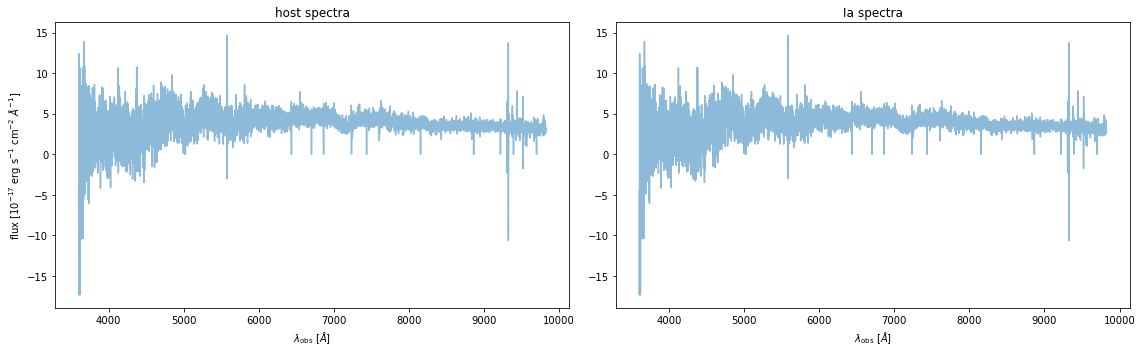

In [353]:
fig, axes = plt.subplots(1,2, figsize=(16,5))

   
ax = axes[0]
ax.plot(waves,fluxes[170], alpha=0.5)

ax = axes[1]
ax.plot(waves, fluxes[170], alpha=0.5)


axes[0].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
            title='host spectra')

axes[1].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            title='Ia spectra')

fig.tight_layout()

### Stack the spectra for image

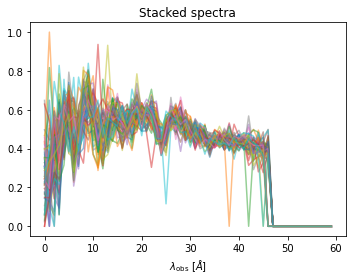

In [360]:
fig,ax= plt.subplots(1,1, figsize=(5,4), tight_layout=True)
ax.plot(fluxes_2d[170], alpha=0.5)
ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            title='Stacked spectra')
fig.tight_layout()

In [336]:
#fig.savefig('stacked_spec.png')

## Picke dump the simulated transients

In [8]:
#rename based of SN Type

import pickle

with open(r'/global/homes/e/esepeku/DESI-Timedomain/coadded_stacked/spectra_20916.data', 'wb') as f:
    pickle.dump(fluxes_2d, f)
    
ids=np.array(fmap["TARGETID"])

with open(r'/global/homes/e/esepeku/DESI-Timedomain/coadded_stacked/IDs_20916.data', 'wb') as f:
    pickle.dump(ids, f)

    
       

NameError: name 'fluxes_2d' is not defined